In [28]:

%matplotlib notebook
import numpy as np
import scipy.signal as signal
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as pyplot
import numpy.random as random
import sounddevice as sd
import math
import rtttl

def dtft(x, samples = 1000):
    wAxis = np.linspace(0, 2 * np.pi, samples)
    n = np.arange(0, x.size)
    result = np.empty(wAxis.size)
    for i, w in enumerate(wAxis):
        result[i] = np.dot(x, np.e **(-1j * w * n)) 
        
    return wAxis, result

# Normalize samples to range (-1, 1)
def normalizeFloat(sound):
    return sound / np.amax(np.abs(sound))

# Applies a delay to the sound
def delaySound(sound, fs, delay):
    padSamples = round(fs * delay)
    return np.pad(sound, (padSamples, 0), mode = "constant", constant_values = 0)

# Zero pads sound to the right
def padSound(sound, samples):
    if sound.size >= samples:
        return sound
    return np.pad(sound, (0, samples - sound.size), mode = "constant", constant_values = 0)
    
def generateSilence(s, fs):
    samples = round(s * fs)
    return np.zeros(samples)

def padAndSum(sound1, sound2):
    padding = max(sound1.size, sound2.size)
    return padSound(sound1, padding) + padSound(sound2, padding)

cMajor = [261.6256, 293.6648, 329.6276, 349.2282, 391.9954, 440.0000, 493.8833, 523.2511]

<IPython.core.display.Javascript object>


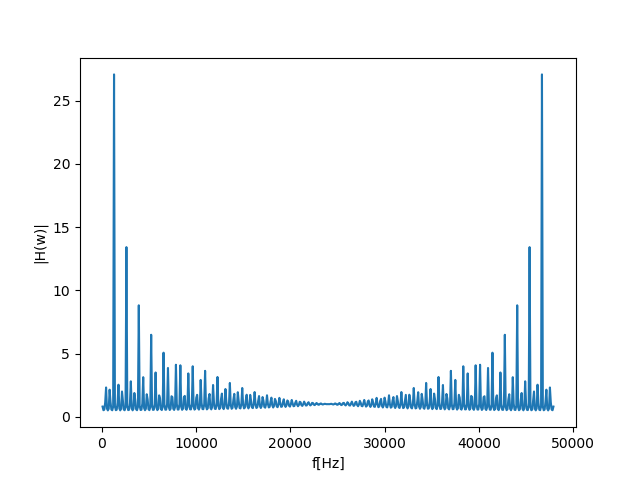

<IPython.core.display.Javascript object>


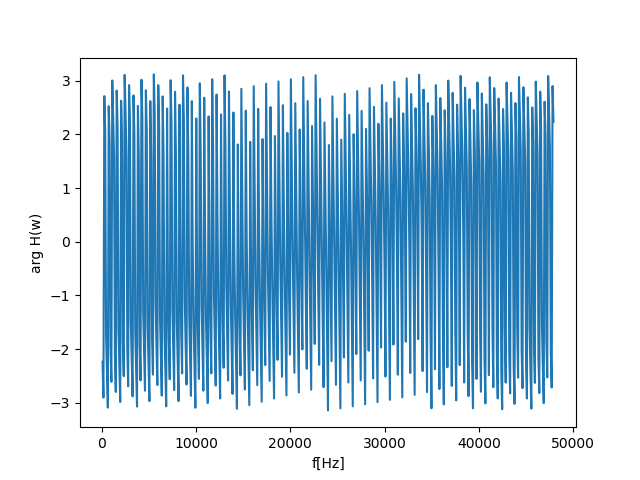

In [196]:
# 2 Tacka

f = 440
FS = 48000
N = round(FS / f - 0.5)
b = np.zeros(N + 1)
b[N] = 2
a = np.zeros(N + 2)
(a[0], a[N], a[N + 1]) = (2, -1, -1)
(w, H) = signal.freqz(b, a, 512, True)
pyplot.figure()
pyplot.xlabel("f[Hz]")
pyplot.ylabel("|H(f)|")
freqAxis = (w * FS) / (2 * np.pi)
pyplot.plot(freqAxis, np.abs(H))
pyplot.figure()
pyplot.xlabel("f[Hz]")
pyplot.ylabel("arg H(f)")
pyplot.plot(freqAxis, np.angle(H))

In [101]:
# Tacka 3
def karplusStrong(f, fs, l):
    N = round(fs / f - 0.5)
    actualFreq = FS / (N + 0.5)
    (b, a) = (np.zeros(N + 1), np.zeros(N + 2))
    (b[N], a[0], a[N], a[N + 1]) = (2, 2, -1, -1)
    totalSamples = round(l * fs)
    noise = random.normal(0, 1, N)
    inputNoise = np.concatenate((noise, np.zeros(totalSamples - N)))
    result = signal.lfilter(b, a, inputNoise)
    normalized = normalizeFloat(result)
    time = np.linspace(0, l, totalSamples)
    return time, actualFreq, normalized

<IPython.core.display.Javascript object>


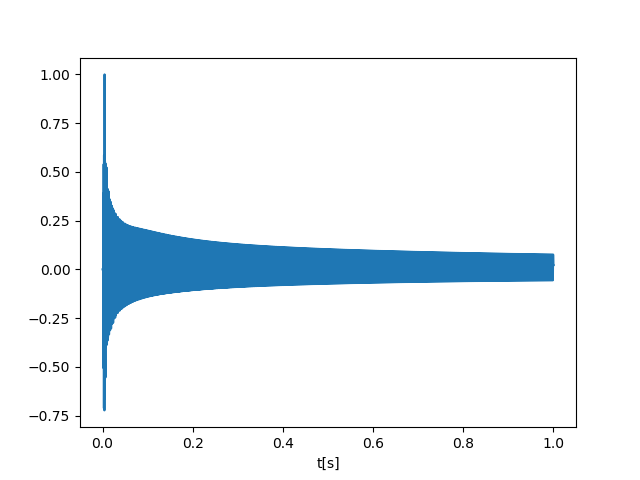

C:\Users\Gebruiker\Anaconda3\envs\odos\lib\site-packages\ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


<IPython.core.display.Javascript object>


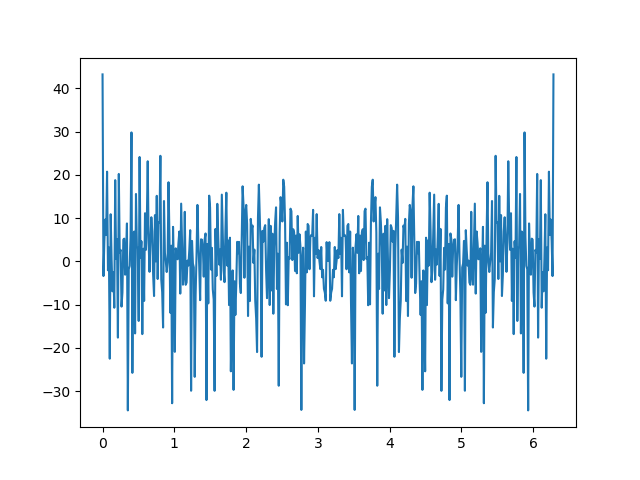

In [102]:
# Tacka 4
l = 1
FS = 48000
(time, actualFreq, synth) = karplusStrong(440, FS, l)
sd.play(synth, FS)
pyplot.figure()
pyplot.xlabel("t[s]")
pyplot.plot(time, synth)
# DTFT OK?
w, X = dtft(synth, 500)
pyplot.figure()
pyplot.plot(w, 20 * np.log10(np.abs(X)))

In [103]:
# Tacka 5

cMajorActualFreq = []
FS = 48000
l = 0.8
result = np.array([])
for i, freq in enumerate(cMajor):
    time, actualFreq, synth = karplusStrong(freq, FS, l)
    if i <= 7:
        cMajorActualFreq.append(actualFreq)
    result = np.concatenate((result, synth))
sd.play(result, FS)

wavfile.write("c major.wav", FS, result.astype(np.float32))
print("C major frequencies: ", cMajor)
print("Actual frequencies: ", cMajorActualFreq)
print("Difference", np.abs(np.array(cMajor) - np.array(cMajorActualFreq)))

C major frequencies:  [261.6256, 293.6648, 329.6276, 349.2282, 391.9954, 440.0, 493.8833, 523.2511]
Actual frequencies:  [261.58038147138967, 293.57798165137615, 329.89690721649487, 349.09090909090907, 391.83673469387753, 438.35616438356163, 492.3076923076923, 524.5901639344262]
Difference [0.04521853 0.08681835 0.26930722 0.13729091 0.15866531 1.64383562
 1.57560769 1.33906393]


<IPython.core.display.Javascript object>


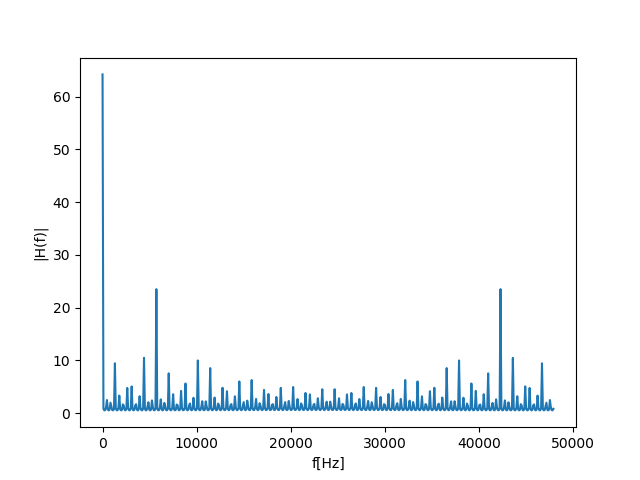

<IPython.core.display.Javascript object>


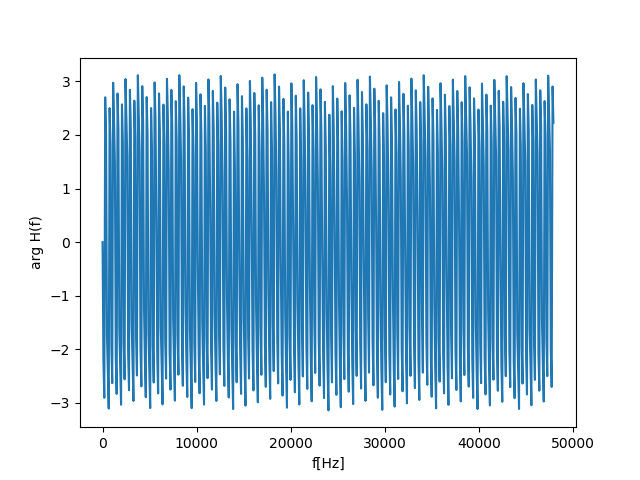

In [297]:
f = 440
FS = 48000

S = 0.1
t60 = 1
N = round(FS / f - 0.5)
b = np.zeros(N + 1)
a = np.zeros(N + 2)
ro = 0.001 ** (1 / (f * t60))

(b[N], a[0], a[N], a[N + 1]) = (1, 1, -ro * (1 - S), -ro * S)
(w, H) = signal.freqz(b, a, 512, True)
pyplot.figure()
pyplot.xlabel("f[Hz]")
pyplot.ylabel("|H(f)|")
freqAxis = (w * FS) / (2 * np.pi)
pyplot.plot(freqAxis, np.abs(H))
pyplot.figure()
pyplot.xlabel("f[Hz]")
pyplot.ylabel("arg H(f)")
pyplot.plot(freqAxis, np.angle(H))

In [98]:
# Tacka 6
def karplusStrong2(f, fs, l, S, t60):
    N = round(fs / f - 0.5)
    actualFreq = FS / (N + 0.5)
    b = np.zeros(N + 1)
    a = np.zeros(N + 2)
    ro = 0.001 ** (1 / (f * t60))
    (b[N], a[0], a[N], a[N + 1]) = (1, 1, -ro * (1 - S), -ro * S)
    totalSamples = round(l * fs)
    noise = random.normal(0, 1, N)
    inputNoise = np.concatenate((noise, np.zeros(totalSamples - N)))
    result = signal.lfilter(b, a, inputNoise)
    normalized = normalizeFloat(result)
    time = np.linspace(0, l, totalSamples)
    return time, actualFreq, normalized

In [99]:
f = 440
FS = 48000
l = 3
params = [(0.1, 1,), (0.2, 1), (0.4, 1), (0.5, 1), 
          (0.8, 1), (0.9, 1), (0.5, 0.5), (0.5, 1), (0.5, 1.5), (0.5, 2)]

for param in params:
    synth = karplusStrong2(f, FS, l, param[0], param[1])[2]
    print(f"S = {param[0]}, t60 = {param[1]}")
    sd.play(synth, FS)
    sd.wait()

S = 0.1, t60 = 1
S = 0.2, t60 = 1
S = 0.4, t60 = 1
S = 0.5, t60 = 1
S = 0.8, t60 = 1
S = 0.9, t60 = 1
S = 0.5, t60 = 0.5
S = 0.5, t60 = 1
S = 0.5, t60 = 1.5
S = 0.5, t60 = 2


In [317]:
# Tacka 7
FS = 48000
l = 0.8
S = 0.5
t60 = 2
params = [(0.1, 1,), (0.2, 1), (0.4, 1), (0.5, 1), 
          (0.8, 1), (0.9, 1), (0.5, 0.5), (0.5, 1), (0.5, 1.5), (0.5, 2)]

def generateCMajor(FS, l, S, t60):
    result = np.array([])
    for freq in cMajor:
        synth = karplusStrong2(freq, FS, l, S, t60)[2]
        result = np.concatenate((result, synth))
    return result

for param in params:
    print(f"S = {param[0]}, t60 = {param[1]}")
    cMajorSynth = generateCMajor(FS, l, param[0], param[1])
    sd.playa(cMajorSynth, FS)
    wavfile.write(f"c major_S={S}_t60={t60}.wav", FS, cMajorSynth.astype(np.float32))
    sd.wait()

S = 0.1, t60 = 1
S = 0.2, t60 = 1
S = 0.4, t60 = 1
S = 0.5, t60 = 1
S = 0.8, t60 = 1
S = 0.9, t60 = 1
S = 0.5, t60 = 0.5
S = 0.5, t60 = 1
S = 0.5, t60 = 1.5
S = 0.5, t60 = 2


In [97]:
# Tacka 8
def karplusStrongFilter(f, fs, l, S, t60, beta):
    N = round(FS / f - 0.5)
    actualFreq = FS / (N + 0.5)
    betaN = math.floor(beta * N)
    b = np.zeros(N + betaN + 1)
    a = np.zeros(N + 2)
    ro = 0.001 ** (1 / (f * t60))
    (b[N], b[N + betaN], a[0], a[N], a[N + 1]) = (1, -1, 1, -ro * (1 - S), -ro * S)
    totalSamples = round(l * fs)
    noise = random.normal(0, 1, N)
    inputNoise = np.concatenate((noise, np.zeros(totalSamples - N)))
    result = signal.lfilter(b, a, inputNoise)
    normalized = normalizeFloat(result)
    time = np.linspace(0, l, totalSamples)
    return time, actualFreq, normalized

In [96]:
f = 440
FS = 48000
l = 3
S = 0.5
t60 = 1
# beta params
params = [0.1, 0.3, 0.5, 0.7, 0.9]

for param in params:
    synth = karplusStrongFilter(f, FS, l, S, t60, param)[2]
    print(f"beta = {param}")
    sd.play(synth, FS)
    sd.wait()

beta = 0.1
beta = 0.3
beta = 0.5
beta = 0.7
beta = 0.9


In [95]:
# Tacka 9
FS = 48000
l = 1
S = 0.5
t60 = 3
params = [0.01, 0.1, 0.5, 0.9]

def generateCMajor(FS, l, S, t60, beta):
    result = np.array([])
    for freq in cMajor:
        synth = karplusStrongFilter(freq, FS, l, S, t60, beta)[2]
        result = np.concatenate((result, synth))
    return result

for param in params:
    print(f"beta = {param}")
    cMajorSynth = generateCMajor(FS, l, S, t60, param)
    sd.play(cMajorSynth, FS)
    wavfile.write(f"c major_S={S}_t60={t60}_beta={param}.wav", FS, cMajorSynth.astype(np.float32))
    sd.wait()

beta = 0.01
beta = 0.1
beta = 0.5
beta = 0.9


In [91]:
# Tacka 10
# Finish implementation
def karplusStrongOD(f, fs, l, S, t60, beta, g):
    N = round(FS / f - 0.5)
    actualFreq = FS / (N + 0.5)
    betaN = math.floor(beta * N)
    b = np.zeros(N + betaN + 1)
    a = np.zeros(N + 2)
    ro = 0.001 ** (1 / (f * t60))
    (b[N], b[N + betaN], a[0], a[N], a[N + 1]) = (1, -1, 1, -ro * (1 - S), -ro * S)
    totalSamples = round(l * fs)
    noise = random.normal(0, 1, N)
    inputNoise = np.concatenate((noise, np.zeros(totalSamples - N)))
    result = signal.lfilter(b, a, inputNoise)
    result *= g
    overdrive = numpy.vectorize(lambda s: s - (s ** 3) / 3)
    result = overdrive(result)
    normalized = normalizeFloat(result)
    time = np.linspace(0, l, totalSamples)
    return time, actualFreq, normalized


In [92]:
# Tacka 11
# Finish implementation
FS = 48000
l = 1
S = 0.5
t60 = 3
g = 1000

def generateCMajor(FS, l, S, t60, beta, g):
    result = np.array([])
    for freq in cMajor:
        synth = karplusStrongFilter(freq, FS, l, S, t60, beta)[2]
        result = np.concatenate((result, synth))
    return result

for param in params:
    print(f"beta = {param}")
    cMajorSynth = generateCMajor(FS, l, S, t60, param)
    sd.play(cMajorSynth, FS)
    wavfile.write(f"c major_S

SyntaxError: EOL while scanning string literal (<ipython-input-92-6d5fa5f5b487>, line 20)

In [87]:
# Tacka 12
def generateChord(freqs, fs, l):
    result = None
    
    # freq can be tuple, in that case first element is frequency, second element is delay in seconds
    for freq in freqs:
        synth = None
        delay = None
        genFreq = None # frequency to generate
        
        if isinstance(freq, tuple):
            genFreq = freq[0]
            delay = freq[1]
        else:
            genFreq = freq
            
        synth = karplusStrong2(genFreq, FS, l, 0.5, 2)[2]
        
        if delay is not None:
            synth = delaySound(synth, fs, delay)
            
        if result is None:
            result = synth
        else:
            result = padAndSum(result, synth)
    
    return normalizeFloat(result)

In [89]:
FS = 48008
l = 5
# C chord
result = generateChord([261.6256, (329.6276, 0.1), (391.9954, 0.2)], FS, l)
sd.play(result, FS)

In [90]:
# Tacka 13
parsedRtttl = None
with open("smb.txt") as file:
     parsedRtttl = rtttl.parse_rtttl(file.read())
    
FS = 48000
result = np.array([])
for tone in parsedRtttl["notes"]:
    (freq, duration) = (tone["frequency"], tone["duration"] / 1000)
    if freq == 0:
        synth = generateSilence(duration, FS)
    else:
        synth = karplusStrong2(freq, FS, duration, 0.1, 2)[2]
    result = np.concatenate((result, synth))

sd.play(result, FS)